In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
"""
基于评分卡的风控模型开发
数据集GiveMeSomeCredit，15万样本数据
https://www.kaggle.com/c/GiveMeSomeCredit/data
使用WOE进行特征变换，IV进行特征筛选，LR构建风控模型，并对模型评分规则进行可解释性说明 
–基本属性：包括了借款人当时的年龄
– 偿债能力：包括了借款人的月收入、负债比率
– 信用往来：两年内35-59天逾期次数、两年内60-89天逾期次数、两年内90天或高于90天逾期的次数
– 财产状况：包括了开放式信贷和贷款数量、不动产贷款或额度数量。
– 其他因素：包括了借款人的家属数量
"""
# 加载数据
df_train = pd.read_csv('./cs-training.csv')
df_train

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


In [3]:
df_test = pd.read_csv('./cs-test.csv')
df_test

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
101498,101499,NaN,0.282653,24,0,0.068522,1400.0,5,0,0,0,0.0
101499,101500,NaN,0.922156,36,3,0.934217,7615.0,8,0,2,0,4.0
101500,101501,NaN,0.081596,70,0,836.000000,NaN,3,0,0,0,NaN
101501,101502,NaN,0.335457,56,0,3568.000000,NaN,8,0,2,1,3.0


In [4]:
# 去掉第一列
df_train = df_train.iloc[:,1:]
df_test = df_test.iloc[:,1:]
df_train

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149995,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


违约率为：0.06684


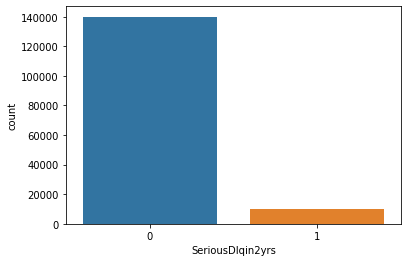

In [5]:
# 对标签字段SeriousDlqin2yrs可视化,countplot以bar的形式展示每个类别的数量
sns.countplot(x = 'SeriousDlqin2yrs',data = df_train)
#查看 违约率
print('违约率为：{}'.format(df_train['SeriousDlqin2yrs'].sum()/len(df_train)))

In [6]:
#查看缺失值
num_null = df_train.isnull().sum()
pd.DataFrame({'列名':num_null.index,'缺失值数量':num_null.values,'缺失值比例':num_null.values/len(df_train)})

,列名,缺失值数量,缺失值比例
0,SeriousDlqin2yrs,0,0.000000
1,RevolvingUtilizationOfUnsecuredLines,0,0.000000
2,age,0,0.000000
3,NumberOfTime30-59DaysPastDueNotWorse,0,0.000000
4,DebtRatio,0,0.000000
5,MonthlyIncome,29731,0.198207
6,NumberOfOpenCreditLinesAndLoans,0,0.000000
7,NumberOfTimes90DaysLate,0,0.000000
8,NumberRealEstateLoansOrLines,0,0.000000
9,NumberOfTime60-89DaysPastDueNotWorse,0,0.000000


In [7]:
# 查看数据
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

In [8]:
#使用中位数进行缺失值填充
df_train.fillna(df_train.median(),inplace = True)
print(df_train.isnull().sum())
df_test.fillna(df_test.median(),inplace = True)
df_test.isnull().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64


SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30-59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                                0
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate                      0
NumberRealEstateLoansOrLines                 0
NumberOfTime60-89DaysPastDueNotWorse         0
NumberOfDependents                           0
dtype: int64

C:\Users\Administrator\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='RevolvingUtilizationOfUnsecuredLines', ylabel='Density'>

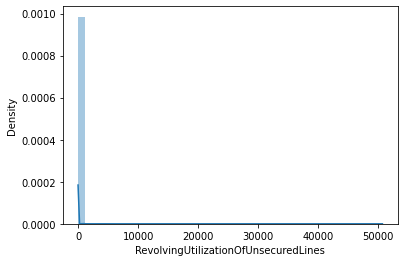

In [9]:
#探索债务情况RevolvingUtilizationOfUnsecuredLines字段
df_train['RevolvingUtilizationOfUnsecuredLines'].describe()
sns.distplot(df_train['RevolvingUtilizationOfUnsecuredLines'])

## 数据分箱

In [10]:
# 查看年龄字段age
df_train['age'].value_counts()
#对于age字段分成6段[-math.inf,25,40,50,60,70,math.inf]
age_bins = [-math.inf,25,40,50,60,70,math.inf]
df_train['bin_age'] = pd.cut(df_train['age'],bins = age_bins)
df_train[['bin_age','age']]

,bin_age,age
0,"(40.0, 50.0]",45
1,"(25.0, 40.0]",40
2,"(25.0, 40.0]",38
3,"(25.0, 40.0]",30
4,"(40.0, 50.0]",49
...,...,...
149995,"(70.0, inf]",74
149996,"(40.0, 50.0]",44
149997,"(50.0, 60.0]",58
149998,"(25.0, 40.0]",30


In [11]:
# 查看家属数量NumberOfDependents 字段
df_train['NumberOfDependents'].value_counts()
#对于NumberOfDependents 划分为6段[-math.inf,2,4,6,8,10,math.inf]
dependent_bin = [-math.inf,2,4,6,8,10,math.inf]
df_train['bin_NumberOfDependents'] = pd.cut(df_train['NumberOfDependents'],bins = dependent_bin)
df_train[['bin_NumberOfDependents','NumberOfDependents']]

,bin_NumberOfDependents,NumberOfDependents
0,"(-inf, 2.0]",2.0
1,"(-inf, 2.0]",1.0
2,"(-inf, 2.0]",0.0
3,"(-inf, 2.0]",0.0
4,"(-inf, 2.0]",0.0
...,...,...
149995,"(-inf, 2.0]",0.0
149996,"(-inf, 2.0]",2.0
149997,"(-inf, 2.0]",0.0
149998,"(-inf, 2.0]",0.0


In [12]:
#查看三种逾期情况字段NumberOfTime30-59DaysPastDueNotWorse，NumberOfTimes90DaysLate，NumberOfTime60-89DaysPastDueNotWorse
# print(df_train['NumberOfTime30-59DaysPastDueNotWorse'].value_counts())
# print(df_train['NumberOfTimes90DaysLate'].value_counts())
# print(df_train['NumberOfTime60-89DaysPastDueNotWorse'].value_counts())

In [13]:
#逾期次数划分为10段[-math.inf,1,2,3,4,5,6,7,8,9,math.inf]
dpd_bins = [-math.inf,1,2,3,4,5,6,7,8,9,math.inf]
df_train['bin_NumberOfTime30-59DaysPastDueNotWorse'] = pd.cut(df_train['NumberOfTime30-59DaysPastDueNotWorse'],bins = dpd_bins)
df_train['bin_NumberOfTimes90DaysLate'] = pd.cut(df_train['NumberOfTimes90DaysLate'],bins = dpd_bins)
df_train['bin_NumberOfTime60-89DaysPastDueNotWorse'] = pd.cut(df_train['NumberOfTime60-89DaysPastDueNotWorse'],bins = dpd_bins)
df_train[['bin_NumberOfTime60-89DaysPastDueNotWorse','NumberOfTime60-89DaysPastDueNotWorse']]

,bin_NumberOfTime60-89DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse
0,"(-inf, 1.0]",0
1,"(-inf, 1.0]",0
2,"(-inf, 1.0]",0
3,"(-inf, 1.0]",0
4,"(-inf, 1.0]",0
...,...,...
149995,"(-inf, 1.0]",0
149996,"(-inf, 1.0]",0
149997,"(-inf, 1.0]",0
149998,"(-inf, 1.0]",0


In [14]:
#对于其余字段即，RevolvingUtilizationOfUnsecuredLines, DebtRatio, MonthlyIncome, 
#NumberOfOpenCreditLinesAndLoans, NumberRealEstateLoansOrLines 分成5段
#采用等频方式分箱
df_train['bin_RevolvingUtilizationOfUnsecuredLines'] = pd.qcut(df_train['RevolvingUtilizationOfUnsecuredLines'],q =5,duplicates = 'drop')
df_train['bin_DebtRatio'] = pd.qcut(df_train['DebtRatio'],q =5,duplicates = 'drop')
df_train['bin_MonthlyIncome'] = pd.qcut(df_train['MonthlyIncome'],q =5,duplicates = 'drop')
df_train['bin_NumberOfOpenCreditLinesAndLoans'] = pd.qcut(df_train['NumberOfOpenCreditLinesAndLoans'],q=5,duplicates ='drop')
df_train['bin_NumberRealEstateLoansOrLines'] = pd.qcut(df_train['NumberRealEstateLoansOrLines'],q = 5,duplicates = 'drop')
#如果遇到分箱数据跨越两个箱子，则drop掉后面的箱子（duplicates)
df_train[['bin_RevolvingUtilizationOfUnsecuredLines',
          'bin_DebtRatio',
          'bin_MonthlyIncome',
          'bin_NumberOfOpenCreditLinesAndLoans',
          'bin_NumberRealEstateLoansOrLines']]

,bin_RevolvingUtilizationOfUnsecuredLines,bin_DebtRatio,bin_MonthlyIncome,bin_NumberOfOpenCreditLinesAndLoans,bin_NumberRealEstateLoansOrLines
0,"(0.699, 50708.0]","(0.468, 4.0]","(8250.0, 3008750.0]","(12.0, 58.0]","(2.0, 54.0]"
1,"(0.699, 50708.0]","(-0.001, 0.134]","(-0.001, 3400.0]","(-0.001, 4.0]","(-0.001, 1.0]"
2,"(0.271, 0.699]","(-0.001, 0.134]","(-0.001, 3400.0]","(-0.001, 4.0]","(-0.001, 1.0]"
3,"(0.0832, 0.271]","(-0.001, 0.134]","(-0.001, 3400.0]","(4.0, 6.0]","(-0.001, 1.0]"
4,"(0.699, 50708.0]","(-0.001, 0.134]","(8250.0, 3008750.0]","(6.0, 9.0]","(-0.001, 1.0]"
...,...,...,...,...,...
149995,"(0.0192, 0.0832]","(0.134, 0.287]","(-0.001, 3400.0]","(-0.001, 4.0]","(-0.001, 1.0]"
149996,"(0.271, 0.699]","(0.468, 4.0]","(5400.0, 8250.0]","(-0.001, 4.0]","(-0.001, 1.0]"
149997,"(0.0832, 0.271]","(4.0, 329664.0]","(3400.0, 5400.0]","(12.0, 58.0]","(-0.001, 1.0]"
149998,"(-0.001, 0.0192]","(-0.001, 0.134]","(5400.0, 8250.0]","(-0.001, 4.0]","(-0.001, 1.0]"


In [15]:
#统计分箱字段
bin_cols = [c for c in df_train.columns.values if c.startswith('bin_')]
bin_cols

['bin_age',
 'bin_NumberOfDependents',
 'bin_NumberOfTime30-59DaysPastDueNotWorse',
 'bin_NumberOfTimes90DaysLate',
 'bin_NumberOfTime60-89DaysPastDueNotWorse',
 'bin_RevolvingUtilizationOfUnsecuredLines',
 'bin_DebtRatio',
 'bin_MonthlyIncome',
 'bin_NumberOfOpenCreditLinesAndLoans',
 'bin_NumberRealEstateLoansOrLines']

In [16]:
print(df_train['SeriousDlqin2yrs'].values)

[1 0 0 ... 0 0 0]


## IV值计算

In [17]:
def cal_IV(df,feature,target = 'SeriousDlqin2yrs'):
    """
    calculate each featrue's IV value
    """
    cols = ['feature','value','value_counts','bad','good']
    lst = []
    #得到字段各bins的样本，bad,good样本数量
    for i in range(df[feature].nunique()): #遍历feature字段的各个取值
        value = list(df[feature].unique())[i]
        #print(value)
        value_counts = df[df[feature] == value][feature].count()
        #print(value_counts)
        bad = df[(df[feature] == value) & (df[target].values == 1)][feature].count()
        good = df[(df[feature] == value) & (df[target].values == 0)][feature].count()
        lst.append([feature,value,value_counts,bad,good])
    #计算目标字段的WOE和IV值
    data = pd.DataFrame(lst,columns = cols)
    data = data[data['bad']>0]
    #print(data)
    #计算bad_total
    bad_total = data['bad'].sum()
    #print(bad_total)
    #计算good_total
    good_total = data['good'].sum()
    #计算bad_rate
    data['bi_bt'] = (data['bad']+0.1) / bad_total
    #print(data['bi_bt'])
    #计算good_rate
    data['gi_gt'] = (data['good']+0.1)  / good_total
    #print(data['gi_gt'])
    #计算WOE
    data['WOE'] = np.log(data['bi_bt']/data['gi_gt'])
    #计算各bins的IV
    data['IV'] = (data['bi_bt'] - data['gi_gt'])*data['WOE']
    #print(data)
    #计算总的IV值
    IV = data['IV'].sum()
    return IV       

In [18]:
#计算bin_age字段的IV值
IV_age = cal_IV(df_train,'bin_age')
print(IV_age)

0.24038329724246474


In [19]:
#统计所有字段的IV值
for col in bin_cols:
    temp_IV = cal_IV(df_train,col)
    print(col,temp_IV)

bin_age 0.24038329724246474
bin_NumberOfDependents 0.014527085645952686
bin_NumberOfTime30-59DaysPastDueNotWorse 0.49264770799721064
bin_NumberOfTimes90DaysLate 0.49178260965773607
bin_NumberOfTime60-89DaysPastDueNotWorse 0.26673927230015004
bin_RevolvingUtilizationOfUnsecuredLines 1.0595325107717979
bin_DebtRatio 0.0594839692616079
bin_MonthlyIncome 0.05623039521337964
bin_NumberOfOpenCreditLinesAndLoans 0.0480197784016992
bin_NumberRealEstateLoansOrLines 0.012092544335127114


### 筛选IV > 0.1的变量：
+ bin_age
+ bin_NumberOfTime30-59DaysPastDueNotWorse
+ bin_NumberOfTimes90DaysLate
+ bin_NumberOfTime60-89DaysPastDueNotWorse
+ bin_RevolvingUtilizationOfUnsecuredLines

In [20]:
# 筛选出的变量
sel_bin_cols = ['bin_age',
                'bin_NumberOfTime30-59DaysPastDueNotWorse',
                'bin_NumberOfTimes90DaysLate',
                'bin_NumberOfTime60-89DaysPastDueNotWorse',
                'bin_RevolvingUtilizationOfUnsecuredLines'
               ] 
sel_fea_cols = ['age',
                'NumberOfTime30-59DaysPastDueNotWorse',
                'NumberOfTimes90DaysLate',
                'NumberOfTime60-89DaysPastDueNotWorse',
                'RevolvingUtilizationOfUnsecuredLines'
               ]

In [21]:
def cal_WOE(df,features,target = 'SeriousDlqin2yrs'):
    """
    calculate WOE of each feature
    """
    df_new = df.copy()
    for f in features:
        df_woe = df_new.groupby(f).agg({target:['sum','count']})
        df_woe.columns = list(map(''.join,df_woe.columns.values))
        #print(df_woe.columns)
        #重命名列名
        df_woe.reset_index(inplace = True)
        df_woe.rename(columns ={target+"sum":"bad",target+'count':'all'},inplace =True)
        #print(df_woe)
        #计算WOE
        df_woe['good'] = df_woe['all'] - df_woe['bad']
        df_woe = df_woe[[f,'bad','good']]
        df_woe['bad_rate'] = (df_woe['bad']+0.1) / df_woe['bad'].sum()
        df_woe['good_rate'] = (df_woe['good']+0.1) / df_woe['good'].sum()
        df_woe['WOE'] = np.log(df_woe['bad_rate']/df_woe['good_rate'])
        #在列名上拼接上_feature,例如_age
        df_woe.columns = [c  if c == f else c +"_" + f for c in list(df_woe.columns.values)]        
        #拼接
        df_new = df_new.merge(df_woe,on = f,how ='left')
        #print(df_new)
    return df_new

In [22]:
df_woe = cal_WOE(df_train,sel_bin_cols)
df_woe

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,...,bad_bin_NumberOfTime60-89DaysPastDueNotWorse,good_bin_NumberOfTime60-89DaysPastDueNotWorse,bad_rate_bin_NumberOfTime60-89DaysPastDueNotWorse,good_rate_bin_NumberOfTime60-89DaysPastDueNotWorse,WOE_bin_NumberOfTime60-89DaysPastDueNotWorse,bad_bin_RevolvingUtilizationOfUnsecuredLines,good_bin_RevolvingUtilizationOfUnsecuredLines,bad_rate_bin_RevolvingUtilizationOfUnsecuredLines,good_rate_bin_RevolvingUtilizationOfUnsecuredLines,WOE_bin_RevolvingUtilizationOfUnsecuredLines
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,...,9033,139094,0.900967,0.993714,-0.09798,5963,24037,0.594764,0.171725,1.242267
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,...,9033,139094,0.900967,0.993714,-0.09798,5963,24037,0.594764,0.171725,1.242267
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,...,9033,139094,0.900967,0.993714,-0.09798,2107,27893,0.210164,0.199273,0.053208
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,...,9033,139094,0.900967,0.993714,-0.09798,877,29123,0.087483,0.208061,-0.866391
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,...,9033,139094,0.900967,0.993714,-0.09798,5963,24037,0.594764,0.171725,1.242267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,...,9033,139094,0.900967,0.993714,-0.09798,497,29503,0.049581,0.210776,-1.447184
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,...,9033,139094,0.900967,0.993714,-0.09798,2107,27893,0.210164,0.199273,0.053208
149997,0,0.246044,58,0,3870.000000,5400.0,18,0,1,0,...,9033,139094,0.900967,0.993714,-0.09798,877,29123,0.087483,0.208061,-0.866391
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,...,9033,139094,0.900967,0.993714,-0.09798,582,29418,0.058059,0.210168,-1.286448


In [23]:
#得到所有woe字段
woe_cols = [c for c in df_woe.columns if 'WOE' in c]
# woe_cols
df_woe[woe_cols]

,WOE_bin_age,WOE_bin_NumberOfTime30-59DaysPastDueNotWorse,WOE_bin_NumberOfTimes90DaysLate,WOE_bin_NumberOfTime60-89DaysPastDueNotWorse,WOE_bin_RevolvingUtilizationOfUnsecuredLines
0,0.228375,1.616778,-0.176663,-0.09798,1.242267
1,0.469574,-0.257813,-0.176663,-0.09798,1.242267
2,0.469574,-0.257813,-0.176663,-0.09798,0.053208
3,0.469574,-0.257813,-0.176663,-0.09798,-0.866391
4,0.228375,-0.257813,-0.176663,-0.09798,1.242267
...,...,...,...,...,...
149995,-1.131899,-0.257813,-0.176663,-0.09798,-1.447184
149996,0.228375,-0.257813,-0.176663,-0.09798,0.053208
149997,-0.084738,-0.257813,-0.176663,-0.09798,-0.866391
149998,0.469574,-0.257813,-0.176663,-0.09798,-1.286448


#### 逻辑回归建模

In [24]:
#数据集切分
from sklearn.model_selection import train_test_split

X = df_woe[woe_cols]
# print(X)
for c in woe_cols:
    print(df_woe[c].value_counts())
y = df_woe['SeriousDlqin2yrs']
# print(y.value_counts())

random_seed = 33

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = random_seed)
print('训练集违约率：',y_train.mean())
print('验证集违约率：',y_test.mean())

 0.228375    35037
-0.084738    34806
 0.469574    32069
-0.688902    27424
-1.131899    17636
 0.562283     3028
Name: WOE_bin_age, dtype: int64
-0.257813    142051
 1.616778      4598
 2.027569      1754
 2.336951       747
 2.436903       342
 2.846279       277
 2.750522       140
 2.710109        54
 1.889061        25
 1.955398        12
Name: WOE_bin_NumberOfTime30-59DaysPastDueNotWorse, dtype: int64
-0.176663    146905
 2.632417      1555
 2.947516       667
 2.820973       293
 3.344398       291
 3.183037       131
 3.040701        80
 4.113388        38
 3.542681        21
 3.653209        19
Name: WOE_bin_NumberOfTimes90DaysLate, dtype: int64
-0.097980    148127
 2.643429      1118
 2.901809       318
 2.829322       270
 3.120823       105
 3.112936        34
 3.718493        16
 2.854529         9
 2.636275         2
 0.238380         1
Name: WOE_bin_NumberOfTime60-89DaysPastDueNotWorse, dtype: int64
 1.242267    30000
 0.053208    30000
-1.447184    30000
-1.286448    30

In [25]:
# 建模
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state = random_seed,class_weight = 'balanced')
model.fit(x_train,y_train)
print(model.score(x_test,y_test))

0.7993666666666667


In [26]:
#使用f1值进行模型评估
from sklearn.metrics import f1_score,accuracy_score

y_pred = model.predict(x_test)
print('f1_score:',f1_score(y_pred,y_test))

f1_score: 0.32057794333446216


In [27]:
#使用交叉验证
from sklearn.model_selection import cross_val_score

model = LogisticRegression(random_state = random_seed,class_weight = 'balanced')

print('f1_score:',cross_val_score(model,x_train,y_train,cv =5,scoring = 'f1').mean())
print('acurracy_score',cross_val_score(model,x_train,y_train,cv = 5,scoring = 'accuracy').mean())

f1_score: 0.3121264935749069
acurracy_score 0.7959750000000001


In [28]:
#超参数max_iter,C交叉验证
def lr_cv(C,max_iter):
    result = cross_val_score(LogisticRegression(
                                               random_state = random_seed,
                                               class_weight = 'balanced',
                                                C = C,
                                               max_iter = max_iter,                                              
                                               ),
                            x_train,y_train,cv = 5,scoring ='f1').mean()
    return result    

In [29]:
#print(y_train.value_counts())

In [30]:
# for c in x_train:
#     print(x_train[c].value_counts())

In [31]:
#使用贝叶斯超参数优化
from bayes_opt import BayesianOptimization

lr_opt = BayesianOptimization(f = lr_cv,
                             pbounds = {
                                        'C':(0.01,10),
                                        'max_iter':(50,500)
                                       })
# lr_opt.maximize()
# print(lr_opt.max)

In [32]:
#最佳参数：'C': 0.785919202468987, 'max_iter': 632.5006911501815}
# C = lr_opt.max['params']['C']
# max_iter = lr_opt.max['params']['max_iter']
model = LogisticRegression(random_state = random_seed,class_weight = 'balanced')
model.fit(x_train,y_train)

print('f1_score:',cross_val_score(model,x_train,y_train,cv =5,scoring = 'f1').mean())
print('acurracy_score',cross_val_score(model,x_train,y_train,cv = 5,scoring = 'accuracy').mean())
print('模型系数：',model.coef_)

f1_score: 0.3121264935749069
acurracy_score 0.7959750000000001
模型系数： [[0.52186154 0.72051841 0.65410969 0.53922077 0.78049879]]


In [33]:
# pip install bayesian-optimization

### 基于评分卡规则生成评分卡

In [34]:
def bin_to_woe(df,selected_features):
    """
    得到分箱的woe值
    """
    df_bin_to_woe = pd.DataFrame(columns = ['feature','bin_feature','woe'])
    for feature in selected_features:
        bin_feature = 'bin_' + feature
        woe = 'WOE_' + bin_feature
        df_temp = df[[woe,bin_feature]].drop_duplicates()
        df_temp.columns = ['woe','bin_feature']
        df_temp['feature'] = feature
        df_temp = df_temp[['feature','bin_feature','woe']]
        #print(df_temp)
        df_bin_to_woe = pd.concat([df_bin_to_woe,df_temp])
    return df_bin_to_woe     
    

In [35]:
df_bin_to_woe = bin_to_woe(df_woe,sel_fea_cols)
print(df_bin_to_woe)

                                    feature       bin_feature       woe
0                                       age      (40.0, 50.0]  0.228375
1                                       age      (25.0, 40.0]  0.469574
5                                       age       (70.0, inf] -1.131899
6                                       age      (50.0, 60.0] -0.084738
15                                      age      (60.0, 70.0] -0.688902
19                                      age      (-inf, 25.0]  0.562283
0      NumberOfTime30-59DaysPastDueNotWorse        (1.0, 2.0]  1.616778
1      NumberOfTime30-59DaysPastDueNotWorse       (-inf, 1.0] -0.257813
13     NumberOfTime30-59DaysPastDueNotWorse        (2.0, 3.0]  2.027569
183    NumberOfTime30-59DaysPastDueNotWorse        (3.0, 4.0]  2.336951
191    NumberOfTime30-59DaysPastDueNotWorse        (4.0, 5.0]  2.436903
251    NumberOfTime30-59DaysPastDueNotWorse        (6.0, 7.0]  2.710109
423    NumberOfTime30-59DaysPastDueNotWorse        (9.0, inf]  2

In [36]:
#基准分
A = 650
#刻度= PDO /ln(2)
B = round(50/np.log(2),2)
print(B)
#模型系数
thetas = model.coef_[0]
print(thetas)

72.13
[0.52186154 0.72051841 0.65410969 0.53922077 0.78049879]


In [37]:
def generate_scorecard(df_bin_to_woe,thetas,features,B =72.13):
    """
    评分卡模型转换:score =-B*theta*woe
    """
    temp_score = pd.Series()
    for i in range(len(features)):
        feature = features[i]
        #print(feature)
        theta = thetas[i]
        #print(theta)
        #print(scorecard[scorecard['feature']== feature]['woe'] * theta *B)
        score = -round(df_bin_to_woe[df_bin_to_woe['feature']== feature]['woe'] * theta *B)
        #print(score)
        temp_score = pd.concat([temp_score,score])
    #print(temp_score)
    df_bin_to_woe['score'] = temp_score.astype('int')  
    scorecard = df_bin_to_woe.drop(['woe'],axis = 1)
    scorecard.columns = ['Variable','Binning','Score']
    return scorecard   
    

In [38]:
scorecard = generate_scorecard(df_bin_to_woe,thetas,sel_fea_cols)
print(scorecard)

                                   Variable           Binning  Score
0                                       age      (40.0, 50.0]     -9
1                                       age      (25.0, 40.0]    -18
5                                       age       (70.0, inf]     43
6                                       age      (50.0, 60.0]      3
15                                      age      (60.0, 70.0]     26
19                                      age      (-inf, 25.0]    -21
0      NumberOfTime30-59DaysPastDueNotWorse        (1.0, 2.0]    -84
1      NumberOfTime30-59DaysPastDueNotWorse       (-inf, 1.0]     13
13     NumberOfTime30-59DaysPastDueNotWorse        (2.0, 3.0]   -105
183    NumberOfTime30-59DaysPastDueNotWorse        (3.0, 4.0]   -121
191    NumberOfTime30-59DaysPastDueNotWorse        (4.0, 5.0]   -127
251    NumberOfTime30-59DaysPastDueNotWorse        (6.0, 7.0]   -141
423    NumberOfTime30-59DaysPastDueNotWorse        (9.0, inf]   -148
1052   NumberOfTime30-59DaysPastDu

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


In [39]:
#对每个字段按降序排列，查看规则
sorted_scorecard = scorecard.groupby('Variable').apply(lambda x: x.sort_values('Score',ascending = False))
sorted_scorecard

Variable  \
Variable                                                                           
NumberOfTime30-59DaysPastDueNotWorse 1      NumberOfTime30-59DaysPastDueNotWorse   
                                     0      NumberOfTime30-59DaysPastDueNotWorse   
                                     6909   NumberOfTime30-59DaysPastDueNotWorse   
                                     10822  NumberOfTime30-59DaysPastDueNotWorse   
                                     13     NumberOfTime30-59DaysPastDueNotWorse   
                                     183    NumberOfTime30-59DaysPastDueNotWorse   
                                     191    NumberOfTime30-59DaysPastDueNotWorse   
                                     251    NumberOfTime30-59DaysPastDueNotWorse   
                                     1052   NumberOfTime30-59DaysPastDueNotWorse   
                                     423    NumberOfTime30-59DaysPastDueNotWorse   
NumberOfTime60-89DaysPastDueNotWorse 0      NumberOfTime60-89DaysPastDueNotWorse   
                                     68976  NumberOfTime60-89DaysPastDueNotWorse   
                                     186    NumberOfTime60-89DaysPastDueNotWorse   
                                     23964  NumberOfTime60-89DaysPastDueNotWorse   
                                     1733   NumberOfTime60-89DaysPastDueNotWorse   
                                     16642  NumberOfTime60-89DaysPastDueNotWorse   
                                     1146   NumberOfTime60-89DaysPastDueNotWorse   
                                     423    NumberOfTime60-89DaysPastDueNotWorse   
                                     2406   NumberOfTime60-89DaysPastDueNotWorse   
                                     6664   NumberOfTime60-89DaysPastDueNotWorse   
NumberOfTimes90DaysLate              0                   NumberOfTimes90DaysLate   
                                     186                 NumberOfTimes90DaysLate   
                                     1733                NumberOfTimes90DaysLate   
                                     13                  NumberOfTimes90DaysLate   
                                     3400                NumberOfTimes90DaysLate   
                                     1298                NumberOfTimes90DaysLate   
                                     1713                NumberOfTimes90DaysLate   
                                     5684                NumberOfTimes90DaysLate   
                                     2910                NumberOfTimes90DaysLate   
                                     3929                NumberOfTimes90DaysLate   
RevolvingUtilizationOfUnsecuredLines 14     RevolvingUtilizationOfUnsecuredLines   
                                     11     RevolvingUtilizationOfUnsecuredLines   
                                     3      RevolvingUtilizationOfUnsecuredLines   
                                     2      RevolvingUtilizationOfUnsecuredLines   
                                     0      RevolvingUtilizationOfUnsecuredLines   
age                                  5                                       age   
                                     15                                      age   
                                     6                                       age   
                                     0                                       age   
                                     1                                       age   
                                     19                                      age   

                                                     Binning  Score  
Variable                                                             
NumberOfTime30-59DaysPastDueNotWorse 1           (-inf, 1.0]     13  
                                     0            (1.0, 2.0]    -84  
                                     6909         (7.0, 8.0]    -98  
                                     10822        (8.0, 9.0]   -102  
                                     13

In [40]:
#把数据映射到分箱
def str_to_int(s):
    '''
    将字符转化为数字
    '''
    if s == '-inf':
        return -999999
    if s == 'inf':
        return 999999
    return float(s)    

In [41]:
def map_value_to_bin(feature_value,feature_to_bin):
    '''
    将value映射到bin
    '''
    for index,row in feature_to_bin.iterrows():
        bins = str(row['Binning'])
        left_open = bins[0] == '('
        right_open = bins[-1] == ')'
        binnings = bins[1:-1].split(',')
        in_range = True
        low_bound = str_to_int(binnings[0])
        up_bound = str_to_int(binnings[1])
        #检查左括号
        if left_open:
            if feature_value <=low_bound:
                in_range = False
        else:
            if feature_value < low_bound:
                in_range = False
        #检查右括号
        if right_open:
            if feature_value >= up_bound:
                in_range = False
        else:
            if feature_value > up_bound:
                in_range = False
        if in_range:
            return row['Binning']

In [42]:
def map_to_score(df,scorecard):
    """
    对数据集应用评分卡规则
    """
    scored_columns = list(scorecard['Variable'].unique())
    #print(scored_columns)
    score =0
    for col in scored_columns:
        #取出评分规则
        feature_to_bin = scorecard[scorecard['Variable'] == col]
        feature_value = df[col]
        selected_bin = map_value_to_bin(feature_value,feature_to_bin)
        temp_score = feature_to_bin[feature_to_bin['Binning'] == selected_bin]
        score += temp_score['Score'].values[0]
    return score
        

In [43]:
def cal_score(df,scorecard,A):
    """
    评分计算
    """
    #map_to_score按评分卡计算
    df['score'] = df.apply(map_to_score,args = (scorecard,),axis =1)
    df['score'] = df['score'].astype('int')
    df['score'] = df['score'] + A
    return df

In [44]:
#随机选择五个好人测试
good_sample = df_train[df_train['SeriousDlqin2yrs'] == 0].sample(5)
good_sample = good_sample[sel_fea_cols]
#对随机选择的人进行评分
good_sample = cal_score(good_sample,scorecard,A)
good_sample

,age,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,RevolvingUtilizationOfUnsecuredLines,score
72724,47,2,0,0,0.994916,499
75691,62,1,1,0,0.673743,698
126694,62,0,0,0,0.000000,773
100884,52,0,2,0,1.000000,476
95312,44,0,0,0,0.137916,715


In [45]:
#随机选择五个坏人测试
good_sample = df_train[df_train['SeriousDlqin2yrs'] == 1].sample(5)
good_sample = good_sample[sel_fea_cols]
#对随机选择的人进行评分
good_sample = cal_score(good_sample,scorecard,A)
good_sample

,age,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,RevolvingUtilizationOfUnsecuredLines,score
20928,43,1,0,0,0.460321,663
47939,37,0,0,0,0.816254,587
123320,53,1,4,2,0.193247,454
35589,30,0,1,1,1.000000,587
145044,34,2,1,0,0.940444,490


### 评分卡模型规则
评分 score = A - B*ln(Odds) = A - B*(θ$^T$x) <br>
其中:A为补偿分，常量；<br>
    B为刻度，常量；<br>
   θ为逻辑回归的模型参数，训练得到。<br>
    x为特征的woe值。<br>
 通过评分卡模型，分数变动与特征woe值变动线性相关。<br>
 